<h1> Dependências

In [9]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

<h1>Carregando Dados

In [10]:
actions = pd.read_csv('ActionList-Reduced.csv')
#Setting time column from string to Float
actions['Time'] = actions['Time'].apply(lambda x: x.replace(',','.')).astype(float)

ref = pd.read_csv('RefPostos-Reduced.csv')
ref = ref.drop(columns=['Classe Posto','Ordem Atividades','Parte'])
#Setting time column from string to Float
ref['Tempo (s)'] = ref['Tempo (s)'].apply(lambda x: x.replace(',','.')).astype(float)

operators = pd.read_csv('Operadores-Reduced.csv')

<h2> Referencia (44 Postos)

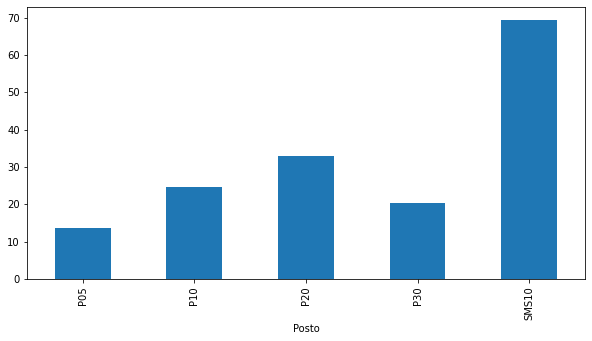

In [11]:
#Graph for referential comparison data
ref.groupby('Posto')['Tempo (s)'].sum().plot(kind="bar", figsize=(10,5))

<h1> Estado Inicial

Iniciando TT com o valor inteiro arredondado para cimada ação mais demorada da lista de ações e definindo a sequência inicial como a ordem dos operadores no arquivo de entrada.

In [59]:
def getInitialTT():
    return math.ceil(max(actions.Time))

In [51]:

def getFirstOperatorsOrder():
    
    order = []
    
    for i in range(0,len(operators.Nome)):
        order = np.append(order, i)
        
    return order

In [352]:
def getStateNumber(state):
    state_number = 0
    
    state_number = state_number + state[0]*6**5
    
    state_number = state_number + state[1]*1
    state_number = state_number + state[2]*6**1
    state_number = state_number + state[3]*6**2
    state_number = state_number + state[4]*6**3
    state_number = state_number + state[5]*6**4
    
    return state_number

In [349]:
type(getStateNumber([11,1,2,3,4,5]))

int

In [123]:
def get_reward(state):

        total_time = state[0]
        order = state[1:len(state)-1]

        #Definindo a distribuição sequencial baseada em TT e order
        accumulator = 0
        full_time = 0
        time_posto = [0] * (len(state)-1)
        index = 0
        action_num = 0

        while(action_num < len(actions.Time)-1 and index < len(operators.Nome)):

            while accumulator < state[0]-actions.Time[action_num]*operators.Eficiencia[order[index-1]]:
                if(action_num < len(actions.Time)-1):
                    accumulator = accumulator + actions.Time[action_num]*operators.Eficiencia[order[index-1]]
                    action_num = action_num + 1
                else:
                    break

            time_posto[index] = accumulator 
            full_time = full_time + accumulator
            accumulator = 0
            index = index + 1

        missing_actions = len(actions.Time)-1 - action_num 
        not_working_operators = len(operators.Nome) - np.count_nonzero(time_posto)
        mean_time = time_posto[time_posto!=0].mean()
        max_time = np.max(time_posto)

        if(missing_actions > 0 or not_working_operators > 0):
            return 0
        else:
            return mean_time

<h1>Ambiente

In [41]:
from enums import *
import random

class LayoutSimulation:
    
    #def __init__(self, tt=np.max(actions.Time),order = getFirstOperatorsOrder()):   

    def take_action(self, action):
        if action == 'INCREASE':
            self.state[0] = self.state[0] + 1
            reward = get_reward(self.state)
        elif action == 'DECREASE':
            self.state[0] = self.state[0] - 1
            reward = get_reward(self.state)
        else:
            aux = self.state[1]
            self.state[1] = self.state[action]
            self.state[action] = aux
            reward = get_reward(self.state)
            
        return self.state, reward

    def reset(self):
        # Reset state to zero, the beginning of the dungeon
        self.state = np.concatenate(([getInitialTT()],getFirstOperatorsOrder()))
        return self.state

<h1>Agente

In [355]:
from enums import *
import random
import math

class Supervisor:
    def __init__(self, learning_rate=0.1, discount=0.95, exploration_rate=1.0, iterations=10000):
        #self.q_table = [ [ 0 for i in range(100*math.factorial(len(operators.Nome))) ] for j in range(len(operators.Nome)+1)] # Spreadsheet (Q-table) for rewards accounting
        self.q_table = [ [ 0 for i in range(785376) ] for j in range(len(operators.Nome)+1)]
        self.learning_rate = learning_rate # How much we appreciate new q-value over current
        self.discount = discount # How much we appreciate future reward over current
        self.exploration_rate = 1.0 # Initial exploration rate
        self.exploration_delta = 1.0 / iterations # Shift from exploration to exploitation

    def get_next_action(self, state):
        if random.random() > self.exploration_rate: # Explore (gamble) or exploit (greedy)
            return self.greedy_action(state)
        else:
            return self.random_action()

    def greedy_action(self, state):
        
        # Choose best rewarding action to take
        best_action = numpy.max(max(self.q_table[state])) 
        
        if best_action == 0:
            return 'INCREASE'
        if best_action == 1:
            return 'DECREASE'
        else:
            return best_action

    def random_action(self):
        rand = random.randint(0, len(operators.Nome) + 1)
        if(rand == 0):
            return 'INCREASE'
        if(rand == 1):
            return 'DECREASE'
        else:
            return rand

    def update(self, old_state, new_state, action, reward):
        # Old Q-table value
        
        print(f'{action} , {getStateNumber(old_state)}')
        old_value = self.q_table[action][getStateNumber(old_state)]
        # What would be our best next action?
        future_action = self.greedy_action(new_state)
        # What is reward for the best next action?
        future_reward = self.q_table[future_action][getStateNumber(new_state)]

        # Main Q-table updating algorithm
        new_value = old_value + self.learning_rate * (reward + self.discount * future_reward - old_value)
        self.q_table[action][getStateNumber(old_state)] = new_value

        # Finally shift our exploration_rate toward zero (less gambling)
        if self.exploration_rate > 0:
            self.exploration_rate -= self.exploration_delta

<h1>Simulação

In [129]:
import random
import json
import argparse
import time

def SimulationStart():
    # parse arguments
    parser = argparse.ArgumentParser()
    parser.add_argument('--learning_rate', type=float, default=0.1, help='How quickly the algorithm tries to learn')
    parser.add_argument('--discount', type=float, default=0.95, help='Discount for estimated future action')
    parser.add_argument('--iterations', type=int, default=2000, help='Iteration count')
    FLAGS, unparsed = parser.parse_known_args()

    agent = Supervisor()

    # setup simulation
    line_layout = LayoutSimulation()
    tt = getInitialTT()
    order = getFirstOperatorsOrder()
    line_layout.reset()
    total_reward = 0 # Score keeping

    print(f'Estado Inicial: {line_layout.state}')
    print('\n')
    #Main loop
    for step in range(FLAGS.iterations):
        old_state = line_layout.state # Store current state
        action = agent.get_next_action(old_state) # Query agent for the next action
        print(f'Agente executou ação: {action}')
        new_state, reward = line_layout.take_action(action) # Take action, get new state and reward
        print(f'Novo Estado: {new_state}')
        print(f'Recompensa: {reward}')
        print('\n')
        agent.update(old_state, new_state, action, reward) # Let the agent update internals

        total_reward += reward # Keep score
        if step % 250 == 0: # Print out metadata every 100th iteration
            print(json.dumps({'step': step, 'total_reward': total_reward}))

        time.sleep(0.0001) # Avoid spamming stdout too fast!

    print("Final Q-table", agent.q_table)


<h1> Iniciar Simulação

In [356]:
SimulationStart()

Estado Inicial: [18.  0.  1.  2.  3.  4.]


Agente executou ação: 3
Novo Estado: [18.  2.  1.  0.  3.  4.]
Recompensa: 0


3 , 145808.0


TypeError: list indices must be integers or slices, not numpy.float64